In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm

### GPU Support
Check if a GPU is available and set the device accordingly.

If you are using Colab, you can manually switch to a CPU device on Colab by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`.

In [5]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
elif USE_GPU and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

#### Data Information
This indicates that there are 2115 trials; each trial has corresponding EEG data from 22 electrodes
over 1000 time bins. Please look at the dataset documentation to know more about the data. E.g.,
Table 2 lists what class labels (769, 770, 771, 772) correspond to. The person files correspond to
the subject performing the task, ranging from 0-8 (inclusive) and may be useful should you want
to see how well you can classify on individual subjects. In the original data / documentation, you
may see that there are 25 channels. We have removed 3 of the channels (so that there are 22)
because those 3 channels were for recording eye movements, not brain activity.


In [6]:

dataset_path = "../../dataset/ECE247_project_data"

X_test = np.load(f"{dataset_path}/X_test.npy")
y_test = np.load(f"{dataset_path}/y_test.npy")

person_train_valid = np.load(f"{dataset_path}/person_train_valid.npy")

X_train_valid = np.load(f"{dataset_path}/X_train_valid.npy")
y_train_valid = np.load(f"{dataset_path}/y_train_valid.npy")

person_test = np.load(f"{dataset_path}/person_test.npy")


In [7]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))

# not used in this model
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [8]:
# split up into valid and invalid
k_fold = 5
total_trail_count = X_train_valid.shape[0]
valid_count = total_trail_count // k_fold



inx_valid = np.random.choice(total_trail_count, valid_count, replace=False)
inx_train = np.array(list(set(range(total_trail_count)).difference(set(inx_valid))))

(x_train, x_valid) = X_train_valid[inx_train], X_train_valid[inx_valid]
(y_train, y_valid) = y_train_valid[inx_train], y_train_valid[inx_valid]

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of training set: (1692, 22, 1000)
Shape of validation set: (423, 22, 1000)
Shape of training labels: (1692,)
Shape of validation labels: (423,)


In [9]:
# Do some more data augmentation / Processing
def change_label(y):
    y_ = y.copy()
    for i in range(len(y)):
        if y_[i] == 769:
            y_[i] = 0
        elif y_[i] == 770:
            y_[i] = 1
        elif y_[i] == 771:
            y_[i] = 2
        else:
            y_[i] = 3
    return y_

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

y_train_formatted = change_label(y_train)
y_valid_formatted = change_label(y_valid)
y_test_formatted = change_label(y_test)

print('Shape of training labels after categorical conversion:',y_train_formatted.shape)
print('Shape of validation labels after categorical conversion:',y_valid_formatted.shape)
print('Shape of test labels after categorical conversion:',y_test_formatted.shape)

Shape of training labels after categorical conversion: (1692,)
Shape of validation labels after categorical conversion: (423,)
Shape of test labels after categorical conversion: (443,)


In [10]:
# For EEG signals (1D), it is common to add a width to make it into a 2D
# input

x_train_formatted = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid_formatted = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
x_test_formatted = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print('Shape of training set after adding width info:',x_train_formatted.shape)
print('Shape of valid set after adding width info:',x_valid_formatted.shape)
print('Shape of test set after adding width info:',x_test_formatted.shape)

Shape of training set after adding width info: (1692, 22, 1000, 1)
Shape of valid set after adding width info: (423, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)


In [11]:

# Split Training and Validation Set
batch_size = 32

# TODO should create custom dataset in the future
x_train_formatted = torch.Tensor(x_train_formatted)
y_train_formatted = torch.Tensor(y_train_formatted)
train_dataset = TensorDataset(x_train_formatted, y_train_formatted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_valid_formatted = torch.Tensor(x_valid_formatted)
y_valid_formatted = torch.Tensor(y_valid_formatted)
valid_dataset = TensorDataset(x_valid_formatted, y_valid_formatted)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

x_test_formatted = torch.Tensor(x_test_formatted)
y_test_formatted = torch.Tensor(y_test_formatted)
test_dataset = TensorDataset(x_test_formatted, y_test_formatted)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(len(train_loader), len(valid_loader), len(test_loader))


53 14 14


### CNN Model and Training

This model follows has 3 conv layer and 2 linear layer following it.

First block: `Conv2D - BN - Conv2D - BN - AvgPool`
Second block: `Conv2D - BN - eLU - AvgPool`
Third block: `Flatten - Linear - eLU - Linear`



In [12]:
from torch import nn
import torch.nn.functional as F

In [13]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.size())  # Print the size of the input tensor
        return x  # Return the unchanged input tensor

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        C = 22 # num of channels
        T = 1000 # num of time intervals

        F1 = 16
        F2 = 10
        F3 = 8

        POOL_SIZE = 2

        alpha = 1.0
        # Convolution Layer

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(C, F1, kernel_size=(1, 4), stride=1, padding='same', bias=False),
            nn.BatchNorm2d(F1),
            # PrintLayer(),
            nn.Conv2d(F1, F2, kernel_size=(1, 4), stride=1, padding='same', bias=False),
            nn.BatchNorm2d(F2),
            # PrintLayer(),
            nn.AvgPool2d(kernel_size=(POOL_SIZE, 1)),
            # PrintLayer()
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(F2, F3, kernel_size=(1, 3), stride=1, padding='same', bias=False),
            nn.BatchNorm2d(F3),
            nn.ELU(alpha=alpha),
            nn.AvgPool2d(kernel_size=(POOL_SIZE , 1)),
        )

        self.flatten = nn.Flatten()

        self.fc_block_1 = nn.Sequential(
            nn.Linear(int(F3 * T / (POOL_SIZE ** 2)), 512),
            nn.ELU(alpha=alpha),
            nn.Linear(512, 4).to(device)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.fc_block_1(x)
        x = self.softmax(x)
        return x


In [15]:
def evaluate(model, test_loader):
    model.eval()
    correct_predicts = 0
    total_labels = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            correct_predicts += (predicted.eq(labels)).sum().item()
            total_labels += len(labels)

    accuracy = correct_predicts / total_labels * 100

    return accuracy

In [28]:
print_every = 1
import matplotlib.pyplot as plt

def train(model, train_loader, valid_loader, criterion, optimizer, epochs=20, plot_acc=False):
    train_acc_tracker = []
    valid_acc_tracker = []

    for epoch in tqdm(range(epochs)):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # print accuracy and loss
        if (epoch + 1) % print_every == 0:
            avg_loss = running_loss / len(train_loader)
            train_accuracy = evaluate(model, train_loader)
            valid_accuracy = evaluate(model, valid_loader)

            train_acc_tracker.append(train_accuracy)
            valid_acc_tracker.append(valid_accuracy)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%')
        

    if plot_acc:
        epochs_length = np.arange(1, epochs + 1) 
        plt.figure(figsize=(10, 6))
        plt.plot(epochs_length, train_acc_tracker, label='Training Accuracy')
        plt.plot(epochs_length, valid_acc_tracker, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

  2%|▏         | 1/50 [00:04<03:58,  4.86s/it]

Epoch [1/50], Loss: 1.3309, Validation Accuracy: 38.06%


  4%|▍         | 2/50 [00:09<03:46,  4.72s/it]

Epoch [2/50], Loss: 1.1662, Validation Accuracy: 45.15%


  6%|▌         | 3/50 [00:14<03:39,  4.67s/it]

Epoch [3/50], Loss: 1.0746, Validation Accuracy: 47.28%


  8%|▊         | 4/50 [00:18<03:32,  4.62s/it]

Epoch [4/50], Loss: 1.0170, Validation Accuracy: 43.74%


 10%|█         | 5/50 [00:23<03:27,  4.61s/it]

Epoch [5/50], Loss: 0.9751, Validation Accuracy: 48.23%


 12%|█▏        | 6/50 [00:27<03:22,  4.60s/it]

Epoch [6/50], Loss: 0.9452, Validation Accuracy: 47.52%


 14%|█▍        | 7/50 [00:32<03:17,  4.59s/it]

Epoch [7/50], Loss: 0.9260, Validation Accuracy: 44.68%


 16%|█▌        | 8/50 [00:36<03:12,  4.57s/it]

Epoch [8/50], Loss: 0.9158, Validation Accuracy: 47.75%


 18%|█▊        | 9/50 [00:41<03:09,  4.62s/it]

Epoch [9/50], Loss: 0.8998, Validation Accuracy: 47.99%


 20%|██        | 10/50 [00:46<03:06,  4.67s/it]

Epoch [10/50], Loss: 0.8889, Validation Accuracy: 44.21%


 22%|██▏       | 11/50 [00:51<03:01,  4.66s/it]

Epoch [11/50], Loss: 0.8668, Validation Accuracy: 47.52%


 24%|██▍       | 12/50 [00:56<03:01,  4.77s/it]

Epoch [12/50], Loss: 0.8589, Validation Accuracy: 48.23%


 26%|██▌       | 13/50 [01:00<02:54,  4.73s/it]

Epoch [13/50], Loss: 0.8504, Validation Accuracy: 49.65%


 28%|██▊       | 14/50 [01:05<02:53,  4.81s/it]

Epoch [14/50], Loss: 0.8454, Validation Accuracy: 47.52%


 30%|███       | 15/50 [01:10<02:48,  4.82s/it]

Epoch [15/50], Loss: 0.8431, Validation Accuracy: 47.28%


 32%|███▏      | 16/50 [01:15<02:46,  4.88s/it]

Epoch [16/50], Loss: 0.8396, Validation Accuracy: 47.28%


 34%|███▍      | 17/50 [01:20<02:42,  4.92s/it]

Epoch [17/50], Loss: 0.8371, Validation Accuracy: 48.70%


 36%|███▌      | 18/50 [01:25<02:35,  4.86s/it]

Epoch [18/50], Loss: 0.8371, Validation Accuracy: 47.99%


 38%|███▊      | 19/50 [01:29<02:27,  4.77s/it]

Epoch [19/50], Loss: 0.8342, Validation Accuracy: 47.75%


 40%|████      | 20/50 [01:34<02:21,  4.70s/it]

Epoch [20/50], Loss: 0.8317, Validation Accuracy: 51.06%


 42%|████▏     | 21/50 [01:38<02:15,  4.66s/it]

Epoch [21/50], Loss: 0.8302, Validation Accuracy: 49.17%


 44%|████▍     | 22/50 [01:43<02:11,  4.68s/it]

Epoch [22/50], Loss: 0.8299, Validation Accuracy: 50.12%


 46%|████▌     | 23/50 [01:49<02:13,  4.93s/it]

Epoch [23/50], Loss: 0.8297, Validation Accuracy: 50.35%


 48%|████▊     | 24/50 [01:54<02:12,  5.11s/it]

Epoch [24/50], Loss: 0.8290, Validation Accuracy: 50.83%


 50%|█████     | 25/50 [01:59<02:05,  5.03s/it]

Epoch [25/50], Loss: 0.8283, Validation Accuracy: 48.94%


 52%|█████▏    | 26/50 [02:04<01:57,  4.91s/it]

Epoch [26/50], Loss: 0.8282, Validation Accuracy: 50.59%


 54%|█████▍    | 27/50 [02:08<01:50,  4.82s/it]

Epoch [27/50], Loss: 0.8283, Validation Accuracy: 49.88%


 56%|█████▌    | 28/50 [02:13<01:44,  4.73s/it]

Epoch [28/50], Loss: 0.8335, Validation Accuracy: 48.46%


 58%|█████▊    | 29/50 [02:18<01:39,  4.74s/it]

Epoch [29/50], Loss: 0.8508, Validation Accuracy: 45.63%


 60%|██████    | 30/50 [02:22<01:34,  4.71s/it]

Epoch [30/50], Loss: 0.8959, Validation Accuracy: 45.63%


 62%|██████▏   | 31/50 [02:27<01:29,  4.72s/it]

Epoch [31/50], Loss: 0.8759, Validation Accuracy: 48.23%


 64%|██████▍   | 32/50 [02:32<01:27,  4.85s/it]

Epoch [32/50], Loss: 0.8571, Validation Accuracy: 46.81%


 66%|██████▌   | 33/50 [02:37<01:21,  4.78s/it]

Epoch [33/50], Loss: 0.8389, Validation Accuracy: 51.54%


 68%|██████▊   | 34/50 [02:41<01:15,  4.72s/it]

Epoch [34/50], Loss: 0.8312, Validation Accuracy: 48.94%


 70%|███████   | 35/50 [02:46<01:11,  4.74s/it]

Epoch [35/50], Loss: 0.8185, Validation Accuracy: 46.81%


 72%|███████▏  | 36/50 [02:51<01:05,  4.68s/it]

Epoch [36/50], Loss: 0.8161, Validation Accuracy: 47.99%


 74%|███████▍  | 37/50 [02:55<01:00,  4.65s/it]

Epoch [37/50], Loss: 0.8139, Validation Accuracy: 47.04%


 76%|███████▌  | 38/50 [03:00<00:56,  4.68s/it]

Epoch [38/50], Loss: 0.8139, Validation Accuracy: 47.04%


 78%|███████▊  | 39/50 [03:05<00:51,  4.69s/it]

Epoch [39/50], Loss: 0.8131, Validation Accuracy: 48.94%


 80%|████████  | 40/50 [03:10<00:47,  4.79s/it]

Epoch [40/50], Loss: 0.8124, Validation Accuracy: 49.65%


 82%|████████▏ | 41/50 [03:14<00:42,  4.77s/it]

Epoch [41/50], Loss: 0.8126, Validation Accuracy: 49.41%


 84%|████████▍ | 42/50 [03:19<00:37,  4.70s/it]

Epoch [42/50], Loss: 0.8122, Validation Accuracy: 49.41%


 86%|████████▌ | 43/50 [03:24<00:32,  4.66s/it]

Epoch [43/50], Loss: 0.8124, Validation Accuracy: 49.65%


 88%|████████▊ | 44/50 [03:28<00:27,  4.64s/it]

Epoch [44/50], Loss: 0.8125, Validation Accuracy: 49.65%


 90%|█████████ | 45/50 [03:33<00:23,  4.66s/it]

Epoch [45/50], Loss: 0.8125, Validation Accuracy: 49.41%


 92%|█████████▏| 46/50 [03:38<00:18,  4.70s/it]

Epoch [46/50], Loss: 0.8119, Validation Accuracy: 50.12%


 94%|█████████▍| 47/50 [03:42<00:13,  4.66s/it]

Epoch [47/50], Loss: 0.8117, Validation Accuracy: 48.70%


 96%|█████████▌| 48/50 [03:47<00:09,  4.68s/it]

Epoch [48/50], Loss: 0.8107, Validation Accuracy: 48.46%


 98%|█████████▊| 49/50 [03:52<00:04,  4.65s/it]

Epoch [49/50], Loss: 0.8109, Validation Accuracy: 48.23%


100%|██████████| 50/50 [03:56<00:00,  4.73s/it]

Epoch [50/50], Loss: 0.8108, Validation Accuracy: 48.70%


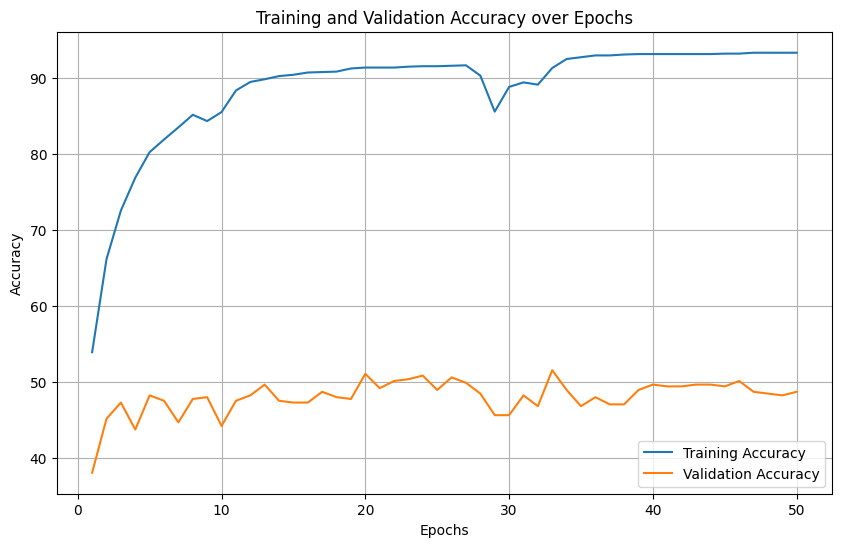

In [29]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Run the training loop again
train(model, train_loader, valid_loader, criterion, optimizer, epochs=50, plot_acc=True)

# Evaluate the model on the test set
# test_accuracy = evaluate(model, test_loader)
# print(f'Test Accuracy: {test_accuracy:.2f}%')

### Ray Tuning (NOT USED ATM)
Use Ray tuning to find the best hyperparameters


In [18]:
import ray
from ray import tune
from ray import train
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

/Users/hchang/miniconda3/envs/ece247/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-07 22:09:13,877	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-03-07 22:09:19,764	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [19]:
# Define the training function
def train_ray(config):
    # TODO Load datasets


    # Define the network and criterion function
    model = ConvNet().to(device)
    criterion = torch.nn.CrossEntropyLoss()

    # TODO: Initialize the optimizer with the hyperparameters defined in the config
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"])

    # TODO: Define the training loop. You can copy this function from the previous section
    for epoch in range(10):  # Loop over the dataset multiple times
        running_loss = 0.0

        # TODO: Report metrics `loss` at the end of each training epoch

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        train.report({'loss': avg_loss})